<a href="https://colab.research.google.com/github/yalexie1/markowitz-efficient-frontier-simulation-and-optimization/blob/main/markowitz-efficient-frontier-simulation-and-optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Markowitz Efficient Frontier Simulation and Optimization**

### Created by Yale Xie

## **Introduction**

When it comes to the stock market, one of the most well-known sayings is "don't put all your eggs in one basket." In practice, this means diversifying (spreading your money) into multiple assets to minimize risk.

**Modern Portfolio Theory (MPT)** is this concept given mathematical rigor. It allows investors to create optimized portfolios that have maximal expected returns for a given level of risk, and it does so by combining assets that don't move perfectly together (low correlation).

In this project, we will take 10 relatively uncorrelated stocks and simulate 10,000 random weightings to find the efficient frontier (the point where you cannot achieve higher return without taking on more risk). In other words, we are answering the following question:

*"Given these 10 stocks, how much of each should I hold to get the maximum possible return for my comfort level?"*

## **Data**

First, let's import our libraries. We use NumPy and pandas for data manipulation, Matplotlib and Seaborn for data visualization, yfinance for data retrieval, and SciPy for algorithmic computation.

In [102]:
# Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import scipy.optimize as sco
from scipy.optimize import minimize
plt.style.use('ggplot')

Next, we choose our 10 stocks and import five years of price data from each.

The 10 stocks used in this project are as follows:

1. AAPL (Apple)
2. MCD (McDonald's)
3. LMT (Lockheed Martin)
4. JNJ (Johnson & Johnson)
5. XOM (Exxon Mobil)
6. JPM (JPMorgan Chase)
7. WMT (Walmart)
8. GLD (SPDR Gold Trust)
9. LIN (Linde)
10. NEE (NextEra Energy)

No two stocks in this list come from the same sector, so we can assume relatively low correlation.


In [103]:
tickers = ['AAPL', 'MCD', 'LMT', 'JNJ', 'XOM', 'JPM', 'WMT', 'GLD', 'LIN', 'NEE']
data = yf.download(tickers, start = "2020-01-01", end = "2025-01-01")["Close"]

/tmp/ipython-input-1561619441.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start = "2020-01-01", end = "2025-01-01")["Close"]
[*********************100%***********************]  10 of 10 completed


In [104]:
data

Ticker,AAPL,GLD,JNJ,JPM,LIN,LMT,MCD,NEE,WMT,XOM
Date,,,,,,,,,,
2020-01-02,72.468285,143.949997,123.290192,119.036438,193.385406,339.388428,174.764786,51.434303,36.433826,53.661720
2020-01-03,71.763725,145.860001,121.862747,117.465561,188.356674,351.600250,174.146774,51.800747,36.112202,53.230305
2020-01-06,72.335564,147.389999,121.710747,117.372177,187.558304,351.064880,176.105179,52.059399,36.038677,53.639008
2020-01-07,71.995377,147.970001,122.454002,115.376770,187.962097,352.246033,176.366287,52.014137,35.704788,53.200031
2020-01-08,73.153488,146.860001,122.437111,116.276817,190.311279,349.297272,179.221176,51.990417,35.582249,52.397762
...,...,...,...,...,...,...,...,...,...,...
2024-12-24,257.037476,241.440002,141.518036,236.221344,420.113190,474.153076,287.289062,70.704491,91.801277,102.633224
2024-12-26,257.853760,243.070007,141.256042,237.030502,418.682495,475.950134,288.080627,70.180824,91.910225,102.720032
2024-12-27,254.439240,241.399994,140.741791,235.110001,417.360291,474.969055,286.927490,69.928680,90.790947,102.710396


Next, we calculate **log returns**. Why log? Because simple percentage returns aren't symmetric (e.g., losing 5% then gaining 5% leaves you with less money than you started with). Log returns are symmetric and additive over time, which makes the math much cleaner for the optimization algorithms.

The formula for log returns is:

$R_t = ln(\frac{P_t}{P_{t-1}})$,

where $P_t$ is the close price of the stock at time $t$.

In [105]:
# dataframe.shift(n) creates a new dataframe except every datapoint is shifted
# down by one column

log_returns = np.log(data / data.shift(1)).dropna()
log_returns

Ticker,AAPL,GLD,JNJ,JPM,LIN,LMT,MCD,NEE,WMT,XOM
Date,,,,,,,,,,
2020-01-03,-0.009770,0.013181,-0.011645,-0.013284,-0.026348,0.035350,-0.003543,0.007099,-0.008867,-0.008072
2020-01-06,0.007937,0.010435,-0.001248,-0.000795,-0.004248,-0.001524,0.011183,0.004981,-0.002038,0.007649
2020-01-07,-0.004714,0.003927,0.006088,-0.017147,0.002151,0.003359,0.001482,-0.000870,-0.009308,-0.008218
2020-01-08,0.015958,-0.007530,-0.000138,0.007771,0.012421,-0.008407,0.016058,-0.000456,-0.003438,-0.015195
2020-01-09,0.021018,-0.005668,0.002962,0.003645,0.007015,0.009444,0.011780,0.007805,0.010278,0.007626
...,...,...,...,...,...,...,...,...,...,...
2024-12-24,0.011413,0.001990,0.003985,0.016310,0.008112,0.003365,0.009226,0.005777,0.025462,0.000940
2024-12-26,0.003171,0.006728,-0.001853,0.003420,-0.003411,0.003783,0.002752,-0.007434,0.001186,0.000845
2024-12-27,-0.013331,-0.006894,-0.003647,-0.008135,-0.003163,-0.002063,-0.004011,-0.003599,-0.012253,-0.000094


We also need the **covariance matrix** (denoted $\Sigma$), which measures how every stock moves relative to every other stock.

Positive covariance means that two stocks generally move the same way, while negative covariance means that two stocks generally move in opposite directions.

We can also create a heatmap of the correlation matrix (which standardizes the covariances to a scale from -1 to 1) to visualize these stock dynamics.

In [106]:
# multiply by 252 for annualization (~252 trading days in a year)
# cov_matrix is a 10x10 matrix

cov_matrix = log_returns.cov() * 252
cov_matrix

Ticker,AAPL,GLD,JNJ,JPM,LIN,LMT,MCD,NEE,WMT,XOM
Ticker,,,,,,,,,,
AAPL,0.100198,0.006402,0.023279,0.042556,0.044401,0.026413,0.035938,0.039897,0.025962,0.031365
GLD,0.006402,0.024162,0.002140,-0.000630,0.006038,0.004361,0.004341,0.010129,0.004631,0.005310
JNJ,0.023279,0.002140,0.038475,0.026151,0.024061,0.023123,0.021094,0.027186,0.017702,0.020327
JPM,0.042556,-0.000630,0.026151,0.105292,0.052007,0.034970,0.040854,0.035151,0.017593,0.063863
LIN,0.044401,0.006038,0.024061,0.052007,0.067237,0.026458,0.033061,0.037322,0.019675,0.037337
LMT,0.026413,0.004361,0.023123,0.034970,0.026458,0.068522,0.025390,0.031045,0.018232,0.037867
MCD,0.035938,0.004341,0.021094,0.040854,0.033061,0.025390,0.054849,0.034159,0.016437,0.030775
NEE,0.039897,0.010129,0.027186,0.035151,0.037322,0.031045,0.034159,0.092973,0.024323,0.029564
WMT,0.025962,0.004631,0.017702,0.017593,0.019675,0.018232,0.016437,0.024323,0.050983,0.013945


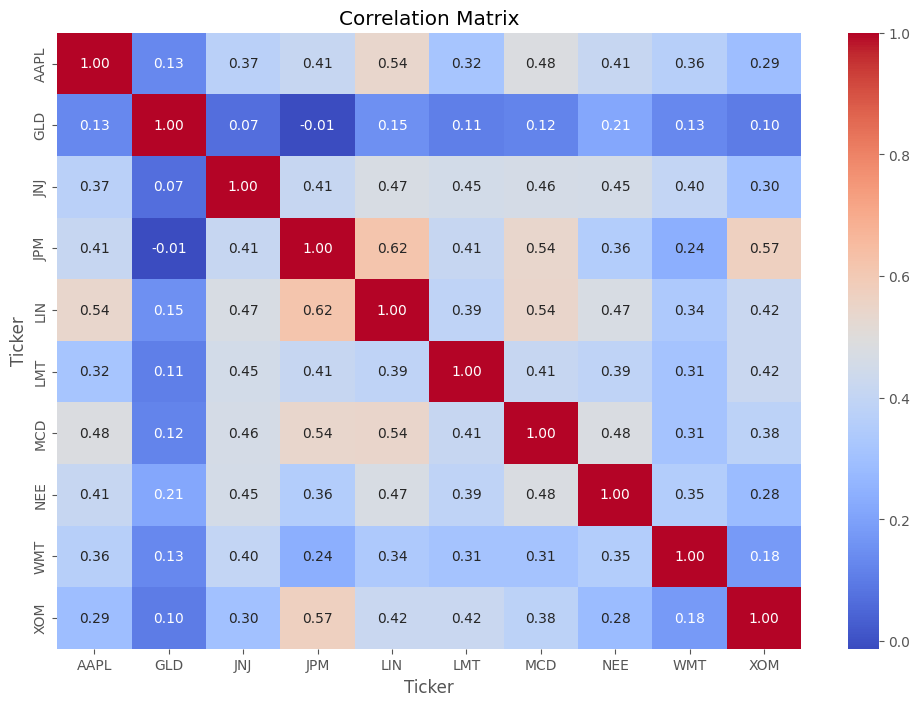

In [107]:
plt.figure(figsize=(12, 8))
sns.heatmap(log_returns.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix') # NOT covariance matrix
plt.show()

An interesting observation is that GLD and JPM (representing gold and the financial sector) have almost zero correlation. In fact, GLD's performance is almost independent from every other stock.

## **Monte Carlo Simulation**

Now, we have arrived at the simulation. To visualize the **Markowitz Efficient Frontier (MEF)**, we'll simulate 10,000 random portfolio weightings to see every possible (not actually *every*, but a lot) risk and return combination available.

Let's break down the steps:

1. **Weights:** We'll generate 10 random numbers and divide by their sum so they'll add up to 1
2. **Expected returns:** We'll dot the weights vector by the average returns vector to get the total portfolio return. Mathematically, this is given as $E(R_p) = w \cdot \mu$, where $R_p$ is the expected return of portfolio $p$, $w$ is the weights vector, and $\mu$ is the average returns vector.
3. **Volatility:** We'll find the volatility by using the following formula: $\sigma_p = \sqrt{w^T \cdot \Sigma \cdot w}$, where $\sigma_p$ is the volatility of porfolio $p$, $w$ is the weights vector, and $\Sigma$ is the covariance matrix.
4. **Sharpe ratio:** We evaluate portfolios based on their Sharpe ratio, a measure of risk-adjusted returns. The formula is as follows: $\frac{R_p - R_f}{\sigma_p}$, where $R_p$ is the return on portfolio $p$, $R_f$ is the risk-free rate (4% for this project), and $\sigma_p$ is the volatility of portfolio $p$.

In [108]:
# preparation

num_simulations = 10000 # 10000 simulations
risk_free_rate = 0.04 # 4% risk-free rate

all_weights = np.zeros((num_simulations, len(tickers))) # matrix of weights
ret_arr = np.zeros(num_simulations) # array of expected returns
vol_arr = np.zeros(num_simulations) # array of volatilities
sharpe_arr = np.zeros(num_simulations) # array of Sharpe ratios

# simulation

for i in range(num_simulations):
  weights = np.array(np.random.random(len(tickers)))
  weights = weights / np.sum(weights) # normalization

  all_weights[i,:] = weights # set the ith row of all_weights to weights
  ret_arr[i] = np.dot(weights, log_returns.mean()) * 252
  vol_arr[i] = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
  sharpe_arr[i] = (ret_arr[i] - risk_free_rate) / vol_arr[i]

In [109]:
# finding the best simulated portfolio

best_idx = sharpe_arr.argmax() # index of the best portfolio
best_return = ret_arr[best_idx] # expected return of the best portfolio
best_vol = vol_arr[best_idx] # volatility of the best portfolio
best_sharpe = sharpe_arr[best_idx] # Sharpe ratio of best portfolio

print(best_idx, best_return, best_vol, best_sharpe)

8895 0.1517701414495229 0.15459218023218335 0.7229999685731473


Now, let's see the MEF. Below is a scatterplot of every simulated portfolio's volatility, expected returns, and Sharpe ratio. The upper left edge of this graph is the MEF and the star represents the best (highest Sharpe ratio) simulated portfolio.

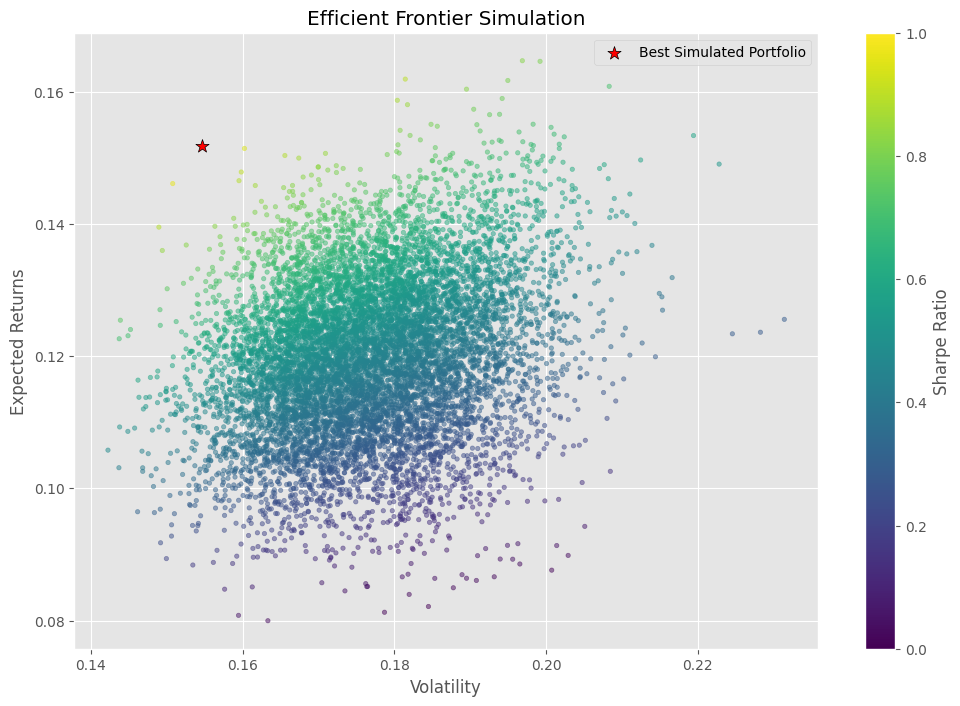

In [110]:
plt.figure(figsize = (12, 8))
plt.scatter(vol_arr, ret_arr, c = sharpe_arr, cmap = 'viridis', s = 10, alpha = 0.5)
plt.scatter(best_vol, best_return, c = 'red', s = 100, marker = '*', edgecolors = 'black', label = 'Best Simulated Portfolio')
plt.xlabel('Volatility')
plt.ylabel('Expected Returns')
plt.colorbar(label = 'Sharpe Ratio')
plt.title('Efficient Frontier Simulation')
plt.legend()
plt.show()

## **Optimization**

This simulation is certainly visually helpful, but it doesn't show the *mathematically* perfect portfolio. To find that, we'll need to stop guessing and use a bit of SciPy optimization, which takes in the following:

- A function want to minimize* (negative Sharpe ratio)
- An initial guess (which we'll set to an equal split)
- A minimization method (sequential least squares programming)
- Bounds (each weight must be between 0 and 1)
- A constraint (the sum of all weights must equal 1)

------


\* Our goal is to maximize the Sharpe ratio, but SciPy's optimization function is designed to minimize things. To get around this, we'll ask SciPy to minimize the negative Sharpe ratio, which is the same as asking it to maximize the Sharpe ratio.

In [111]:
# helper function to get returns, volatility, and Sharpe ratio
def get_ret_vol_sr(weights):
    weights = np.array(weights)
    ret = np.dot(weights, log_returns.mean()) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sr = (ret - risk_free_rate) / vol
    return np.array([ret, vol, sr])

# function we want to minimize
def neg_sharpe(weights):
    return get_ret_vol_sr(weights)[2] * -1

# constraint
# eq = equality constraint (np.sum(x) - 1 must equal 0)
check_sum = ({'type':'eq','fun': lambda x: np.sum(x) - 1})

# bounds
# a tuple of (0, 1) tuples
bounds = tuple((0, 1) for _ in range(len(tickers)))

# initial guess [0.1, 0.1, ... 0.1]
init_guess = [1/len(tickers)] * len(tickers)

# run optimizer
# SLSQP = sequential least squares programming
results = minimize(neg_sharpe, init_guess, method = 'SLSQP', bounds = bounds, constraints = check_sum)

In [112]:
opt_vals = get_ret_vol_sr(results.x) # optimal values

print(f"Optimal Return: {opt_vals[0]:.2f}")
print(f"Optimal Volatility: {opt_vals[1]:.2f}")
print(f"Optimal Sharpe: {opt_vals[2]:.2f}")

print("\n--- Optimal Portfolio Weights ---")
for ticker, weight in zip(tickers, results.x):
    if weight > 0.001: # filter out insignificant weights
        print(f"{ticker}: {weight*100:.2f}%")

Optimal Return: 0.17
Optimal Volatility: 0.16
Optimal Sharpe: 0.83

--- Optimal Portfolio Weights ---
AAPL: 27.55%
MCD: 36.25%
LIN: 34.37%
NEE: 1.82%


These numbers represent the mathematical ideal portfolio. With a Sharpe ratio **~15% higher** (0.83 compared to 0.72) than the simulated version, this portfolio is significantly better.

And with this, we've answered our original question. Given these ten stocks, the way to get the highest risk-adjusted expected return is by allocating **27.55% in AAPL, 36.25% in MCD, 34.37% in LIN, and 1.82% in NEE**.

## **Final Visualization**

We have solved our original problem, but I think we can make a visualization that captures everything we want. Specifically, I want to add:

1. **The efficient frontier line**
- We'll do this by finding the lowest volatility for 50 different target return levels and plotting them
2. **A minimum volatility portfolio**
- Important for investors who are simply looking for safe investments with optimal returns
3. **Individual stock portfolios**
- Compare the performance of a optimally diversified portfolio against any singular stock

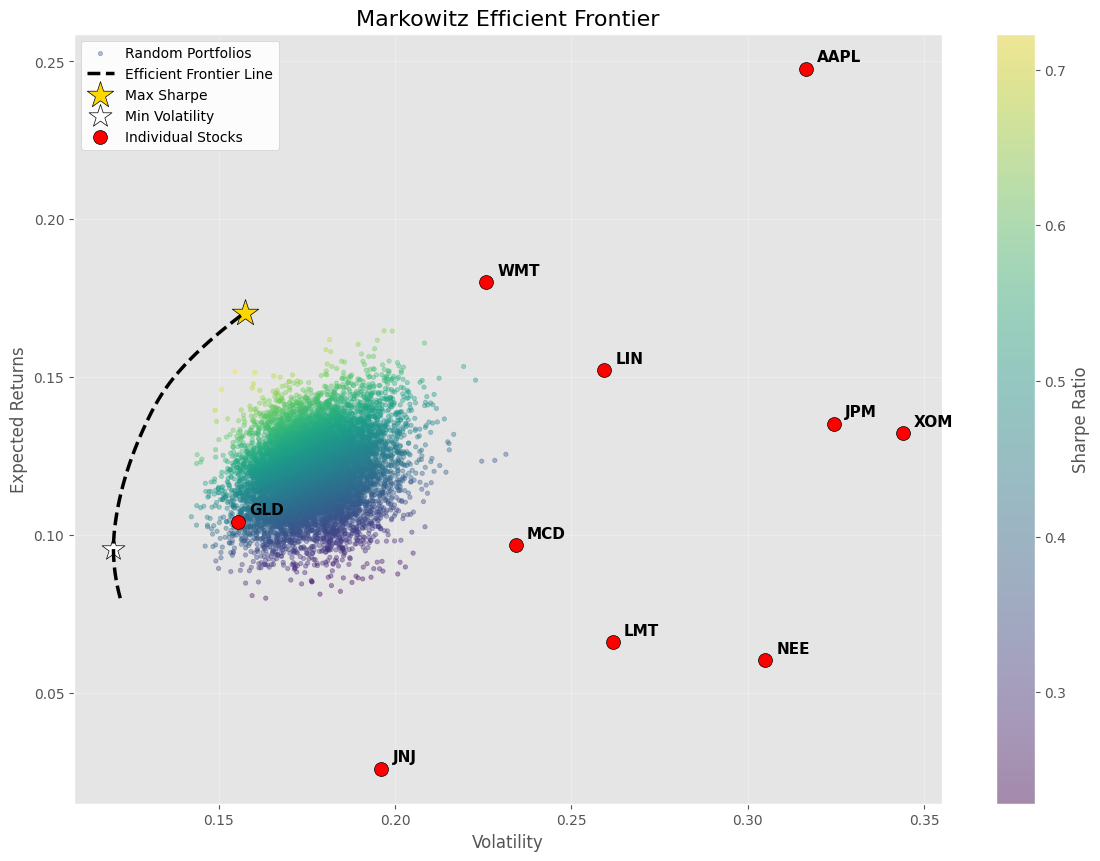

In [115]:
frontier_y = np.linspace(ret_arr.min(), opt_vals[0], 50) # 50 target returns
frontier_x = [] # corresponding volatilities

# helper function
def get_volatility(weights):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

# get the corresponding optimized volatilities for target returns
for possible_return in frontier_y:
    # constraints: sum of weights = 1, AND return = target
    cons = ({'type':'eq', 'fun': lambda x: np.sum(x) - 1},
            {'type':'eq', 'fun': lambda x: np.sum(log_returns.mean() * x) * 252 - possible_return})

    # minimize volatility
    result = minimize(get_volatility, init_guess, method = 'SLSQP', bounds = bounds, constraints = cons)
    frontier_x.append(result.fun) # append the minimized volatility value

# find the absolute minimum volatility portfolio metrics
min_vol_res = minimize(get_volatility, init_guess, method = 'SLSQP', bounds = bounds, constraints = check_sum)
min_vol_ret, min_vol_risk, _ = get_ret_vol_sr(min_vol_res.x) # return and volatility

# master plot
plt.figure(figsize = (14, 10))

# cloud of simulated portfolios
plt.scatter(vol_arr, ret_arr, c = sharpe_arr, cmap = 'viridis', s = 10, alpha = 0.4, label = 'Random Portfolios')
plt.colorbar(label = 'Sharpe Ratio')

# frontier line
plt.plot(frontier_x, frontier_y, 'k--', linewidth = 2.5, label = 'Efficient Frontier Line')

# important points
plt.scatter(opt_vals[1], opt_vals[0], c = 'gold', s = 400, marker = '*',
            edgecolors = 'black', label = 'Max Sharpe')
plt.scatter(min_vol_risk, min_vol_ret, c = 'white', s = 300, marker = '*',
            edgecolors = 'black', label = 'Min Volatility')

# individual stocks
ind_rets = log_returns.mean() * 252 # individual returns
ind_vols = log_returns.std() * np.sqrt(252) # individual volatilities

plt.scatter(ind_vols, ind_rets, c = 'red', marker = 'o', s=100, edgecolors = 'black', label = 'Individual Stocks')

# annotate stock names
for ticker in tickers:
    plt.annotate(ticker, (ind_vols[ticker], ind_rets[ticker]),
                 xytext = (8,5), textcoords = 'offset points', fontsize = 11, weight = 'bold')

# formatting
plt.title('Markowitz Efficient Frontier', fontsize = 16)
plt.xlabel('Volatility', fontsize = 12)
plt.ylabel('Expected Returns', fontsize = 12)
plt.legend(loc = 'upper left', fontsize = 10, frameon = True, facecolor = 'white', framealpha = 0.9)
plt.grid(True, alpha = 0.3)

plt.show()

## **Limitations**

While MPT is great (it literally won Markowitz a Nobel Prize), it relies on a few assumptions that break down in the real world.

1. The model assumes **stock returns follow a normal distribution**, which implies that extreme events are statistically impossible (untrue). In reality, stock returns have fatter tails (better modeled by a t-distribution), which means this model likely underestimates the true probability of a catastrophic loss.
2. The model assumes that **correlations are constant**. However, just because gold and stocks were uncorrelated for the last 5 years doesn't mean they will be uncorrelated tomorrow. In a panic, investors sell everything, making correlations go to 1 and rendering our model useless in the darkest hour.
3. The model assumes that **the past accurately predicts the future**. We used historical mean and historical covariance as inputs for future expected returns, but market regime changes often cause stocks to become stronger/weaker and/or more stable/volatile.
4. The model assumes that **one can buy and sell instantly with zero cost, zero taxes, and infinite liquidity**. In reality, transaction costs and taxes reduce actual returns.